In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

# Import package
import tweepy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import csv
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from googletrans import Translator

[]


# API Authentication

Store OAuth authentication credentials in relevant variables

In [23]:
#---------------------------------------------------------------------------------------------------------------------------
# API Authentication

# Store OAuth authentication credentials in relevant variables
access_token = "access_token here"
access_token_secret = "access_token_secret here"
consumer_key = "consumer_key here"
consumer_secret = "consumer_secret here"

# Pass OAuth details to tweepy's OAuth handler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_token_secret)

# cria um objeto api
api = tweepy.API(auth)
sents = []

# create an object called 'customStreamListener'

In [24]:
#create an object called 'customStreamListener'
def twitter_stream_listener(filter_track):
    
    # class foi stream listener
    class classStreamListener(tweepy.StreamListener):
        
        def on_status(self, status):

            # translator ---------------------------------------------------------------------------------------------------
            def translate_text(status_text):
                analysis = TextBlob(status_text)
                lang_detected = analysis.detect_language()
               
                if analysis.detect_language() != 'en':
                    if analysis.detect_language() == 'nl': # got some error with nl language
                        trans = analysis
                    else:
                        #trans = TextBlob(str(analysis.translate(from_lang=lang_detected, to='en')))
                        trans = Translator().translate(status_text).text
                else:
                    trans = analysis
                    
                return trans
            
            
            # sentiment analyzer -------------------------------------------------------------------------------------------
            def sentiment_analyzer_scores(tx_trans):
                #score analyser
                score = SentimentIntensityAnalyzer().polarity_scores(tx_trans)
                lb = score['compound']
                if lb >= 0.05:
                    return 1
                elif (lb > -0.05) and (lb < 0.05):
                    return 0
                else:
                    return -1
            
            tx_trans = translate_text(status.text.encode('latin1', errors='ignore').decode('latin1', errors='ignore'))
            st = sentiment_analyzer_scores(tx_trans)

##          print('lang_detected =', lang_detected) # DEBUG
##          print(lb) # DEBUG       
##          print(tx_trans) # DEBUG mostra o valor real do sentimento antes do filtro # DEBUG
##          print('') # DEBUG
##          print('Mensagem', status.text.encode('latin1', errors='ignore').decode('latin1', errors='ignore')) # DEBUG
##          print('O tipo é', type(status.text)) # DEBUG
##          print('comeco tweepy') # DEBUG
##          print(status.text.encode('latin1', errors='ignore').decode('latin1', errors='ignore')) # DEBUG
##          print('fim tweepy') # DEBUG
##          print('') # DEBUG

            
            #list_tweets --------------------------------------------------------------------------------------------------
            def list_tweets(status_text):
                tw = [] # lista de tweets inicialmente vazia
                tw.append(status_text)
                return tw

            tw = list_tweets(status.text.encode('latin1', errors='ignore').decode('latin1', errors='ignore'))
            
##          print('O tipo é', type(tw)) # DEBUG
##          print('comeco lista') # DEBUG
##          print(tw) # DEBUG
##          print('fim lista') # DEBUG
##          print('') # DEBUG

            
            ## remove patterns ---------------------------------------------------------------------------------------------
            def remove_pattern(input_txt, pattern):
                r = re.findall(pattern, input_txt)
                for i in r:
                    input_txt = re.sub(i, '', input_txt)        
                return input_txt

            
            ## clean tweets ------------------------------------------------------------------------------------------------
            def clean_tweets(lst):
                # remove twitter Return handles (RT @xxx:)
                lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
                # remove twitter handles (@xxx)
                #lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
                lst = np.core.defchararray.replace(lst, "@", " ")
                # remove URL links (httpxxx)
                lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
                # remove special characters, numbers, punctuations (except for #)
                lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")
                return lst

            tw = clean_tweets(tw)
            
##          print('O tipo é', type(tw)) # DEBUG
##          print('comeco array') # DEBUG
##          print(tw) # DEBUG
##          print('fim array') # DEBUG
##          print('') # DEBUG

            
            ## tweets analyzer and graph plot --------------------------------------------------------------------------------
            def anl_tweets(tx_trans, title='Tweets Sentiment'):
                st = sentiment_analyzer_scores(tx_trans)
                sents.append(st)
                ax = sns.distplot(sents, kde=False, bins=5)
                ax.set(xlabel='Negative                            Neutral                             Positive', ylabel='#Tweets', title="Tweets of @"+title)
                plt.show(block=False)    
                return sents

            tw_sent = anl_tweets(tx_trans)
            
##          print('tw', tw) # DEBUG
##          print('st', st) # DEBUG
##          print('O tipo de st é', type(st)) # DEBUG
##          print('sents', sents) # DEBUG
##          print('O tipo de sents é', type(sents))
##          print('tw_sent', tw_sent) # DEBUG
##          print('O tipo de tw_sent é', type(tw_sent)) # DEBUG

#---------------------------------------------------------------------------------------------------------------------------
# write data in file

            print('#---------------------------------------------------------------------------------------------------------------------------')
            print('')
            print(status.author.screen_name, status.created_at, tw)
            # Writing status data
            with open('OutputStreaming.txt', 'a') as f:
                writer = csv.writer(f)
##                writer.writerow([status.author.screen_name, status.created_at, tw, st])
                if st == 1:
                    print('O sentimento da mensagem é POSITIVE')
                    writer.writerow([status.author.screen_name, status.created_at, tw, 'POSITIVE'])
                elif st == 0:
                    print('O sentimento da mensagem é NEUTRAL')
                    writer.writerow([status.author.screen_name, status.created_at, tw, 'NEUTRAL'])
                else:
                    print('O sentimento da mensagem é NEGATIVE')
                    writer.writerow([status.author.screen_name, status.created_at, tw, 'NEGATIVE'])
            print('')
            
#---------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------
# error            
        def on_error(self, status_code):
            if status_code == 420:
                print('Encountered error code 420. Disconnecting the stream')
            # returning False in on_data disconnects the stream
                return False
            else:
                print('Encountered error with status code: {}'.format(status_code))
                return True  # Don't kill the stream

#---------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------
# timeout
        def on_timeout(self):
            print(sys.stderr, 'Timeout...')
            return True # Don't kill the stream

#---------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------
# Writing csv titles
    with open('OutputStreaming.txt', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Author', 'Date', 'Text', 'Sentimental'])

#---------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------
    streamingAPI = tweepy.streaming.Stream(auth, classStreamListener())
    
    streamingAPI.filter(track=filter_track)

    f.close()

#---------------------------------------------------------------------------------------------------------------------------

#filter_track = ['realDonaldTrump','wall']
#filter_track = ['jairbolsonaro','previdencia']

# filter_track

-------------------------------------------------------------
API TWITTER Portuguese ANALYZER
-------------------------------------------------------------
Please Type the filter that you want to analyze in Twitter
e.g. "jairbolsonaro" and "previdencia"
To FINISH, press ctrl+c and visualize the sentimental graph
First filter: realDonaldTrump
Second filter: wall


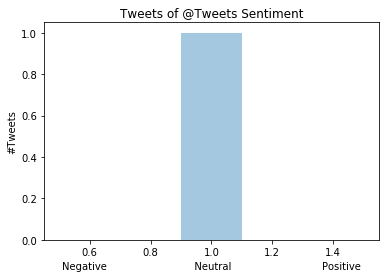

#---------------------------------------------------------------------------------------------------------------------------

DoorSlammersDR 2019-06-11 17:29:02 [' Congratulations to the 2019 Indianapolis 500 Winner  IMS,  SimonPagenaud and  Team_Penske!  IndyCar ']
O sentimento da mensagem é POSITIVE



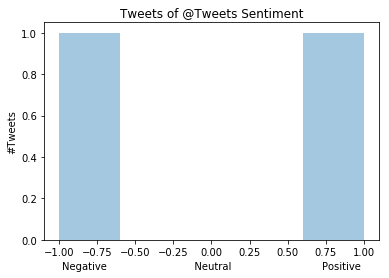

#---------------------------------------------------------------------------------------------------------------------------

crespo_yraida1 2019-06-11 17:29:04 ['Preso político ? Si como nie ! \n\n#MudyPsuv son Concubinos !\n\nSON ENEMIGOS DE LOS VENEZOLANOS !\n\n jguaido ']
O sentimento da mensagem é NEGATIVE



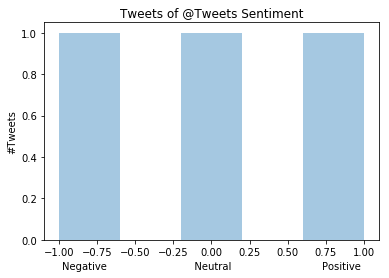

#---------------------------------------------------------------------------------------------------------------------------

Spectator1121 2019-06-11 17:29:03 [' realDonaldTrump When will he stroke out..... ']
O sentimento da mensagem é NEUTRAL



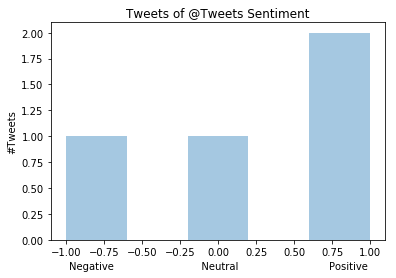

#---------------------------------------------------------------------------------------------------------------------------

PBarone160 2019-06-11 17:29:04 ['  URGENT CALL TO ACTION \nWe need all American Patriots to call the unaccountable open-borders globalists at the IB']
O sentimento da mensagem é POSITIVE



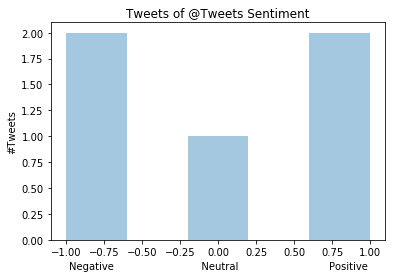

#---------------------------------------------------------------------------------------------------------------------------

Jacquel25102704 2019-06-11 17:29:04 [' Every day,  realDonaldTrump reminds us what a complete and total idiot he is. Every. Single. Day.']
O sentimento da mensagem é NEGATIVE



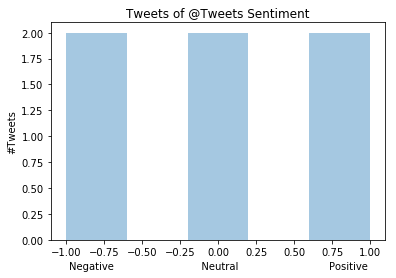

#---------------------------------------------------------------------------------------------------------------------------

TheRealSatchi 2019-06-11 17:29:04 [' POTUS holds up what appears to be a blank piece of paper claiming it contains the Mexican deal. Refuses to answer when I as']
O sentimento da mensagem é NEUTRAL



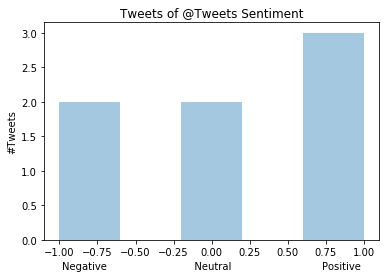

#---------------------------------------------------------------------------------------------------------------------------

zene55 2019-06-11 17:29:04 ['You are stuck in a rut Juan. Trump won. Russia put out some FB ads and some tweets. No proof it swayed anyone. You ']
O sentimento da mensagem é POSITIVE



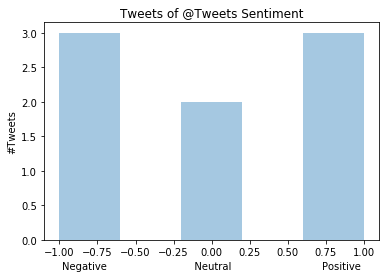

#---------------------------------------------------------------------------------------------------------------------------

JohnZajaros 2019-06-11 17:29:04 ['I wondered who he was telling to be quiet. Unreal! Did you catch that empty piece of paper? UN-F*CKING-BELIEVABLE! ']
O sentimento da mensagem é NEGATIVE



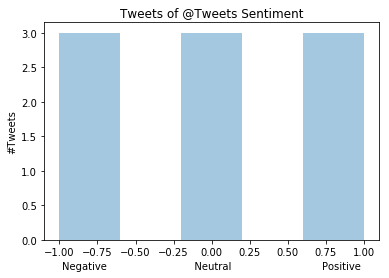

#---------------------------------------------------------------------------------------------------------------------------

gaddzook 2019-06-11 17:29:04 [' senatemajldr  SenateGOP  HouseGOP you must insure this is DONE!']
O sentimento da mensagem é NEUTRAL



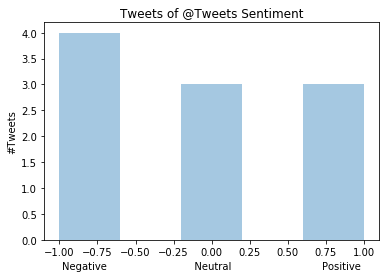

#---------------------------------------------------------------------------------------------------------------------------

GILLIETATHAM 2019-06-11 17:29:04 [' Good grief. ']
O sentimento da mensagem é NEGATIVE



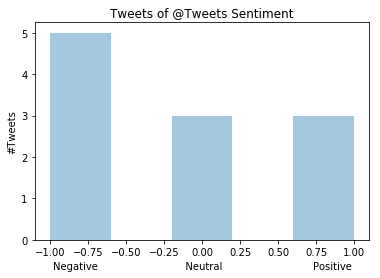

#---------------------------------------------------------------------------------------------------------------------------

HominidAd 2019-06-11 17:29:04 [' realDonaldTrump WEAK AF']
O sentimento da mensagem é NEGATIVE



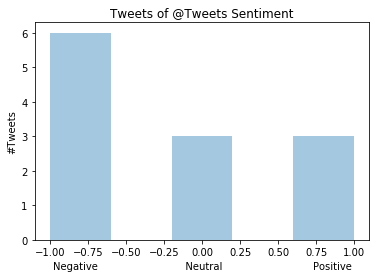

#---------------------------------------------------------------------------------------------------------------------------

alicia19671 2019-06-11 17:29:04 ['  TeamTrump knows that pushing against the grain can pay off. \n\nWhen we spent money in WI and MI in 2016 and sent  realDonald']
O sentimento da mensagem é NEGATIVE



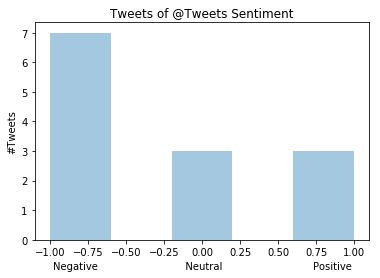

#---------------------------------------------------------------------------------------------------------------------------

AVechera 2019-06-11 17:29:04 [' Three times POTUS tells me to be quiet as I ask him about the accusations he is lying to the American public.  realDonaldT']
O sentimento da mensagem é NEGATIVE



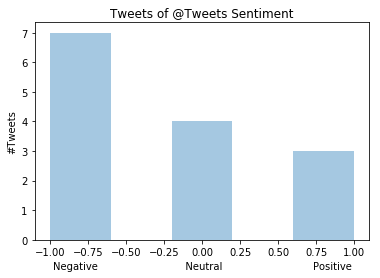

#---------------------------------------------------------------------------------------------------------------------------

jbart1055 2019-06-11 17:29:04 [' maddezmom  BrianKarem  realDonaldTrump Waiting for the moment ']
O sentimento da mensagem é NEUTRAL



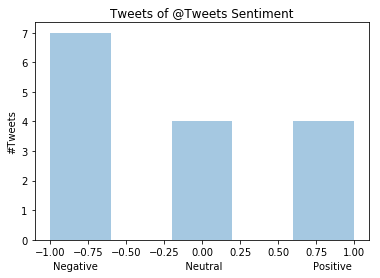

#---------------------------------------------------------------------------------------------------------------------------

SMTAZ61 2019-06-11 17:29:05 [' realDonaldTrump You are doing a fine job of fucking up the Presidency all by your little self.   One way or anothe ']
O sentimento da mensagem é POSITIVE



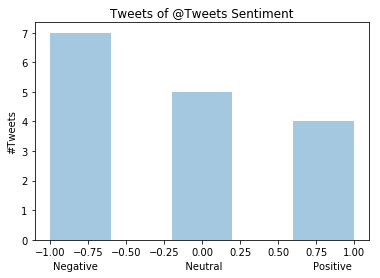

#---------------------------------------------------------------------------------------------------------------------------

JustinGil10 2019-06-11 17:29:05 [' WhiteHouse  realDonaldTrump  POTUS  FLOTUS  ArianaGrande  netanyahu  IsraeliPM  IsraeliPM_heb  SenateDems ']
O sentimento da mensagem é NEUTRAL



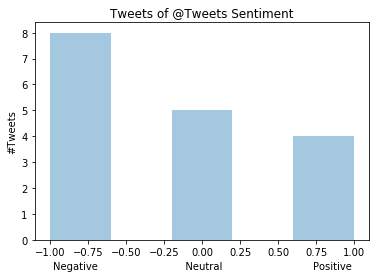

#---------------------------------------------------------------------------------------------------------------------------

Sallyevens2 2019-06-11 17:29:05 [' Alert to  realDonaldTrump our enemies are at the southern border now, locking the gates OPEN. &amp; those enemies are Obama hold']
O sentimento da mensagem é NEGATIVE



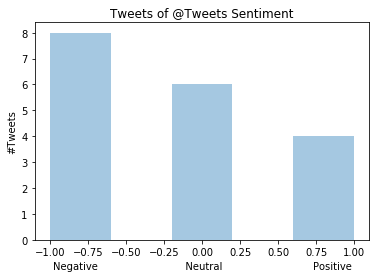

#---------------------------------------------------------------------------------------------------------------------------

_LittleIndian 2019-06-11 17:29:05 [' What day yo term over? ']
O sentimento da mensagem é NEUTRAL



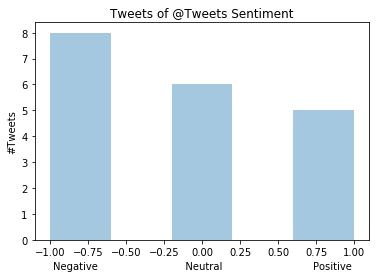

#---------------------------------------------------------------------------------------------------------------------------

peri_gisele 2019-06-11 17:29:05 ['  RepMattGaetz  JohnWDean  realDonaldTrump "Rips" sort of implies there was at least some truth to your grandstanding diatrib']
O sentimento da mensagem é POSITIVE



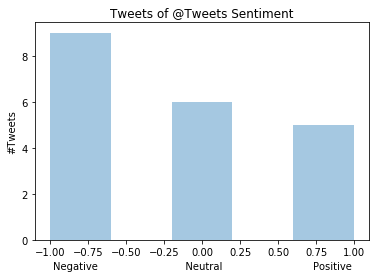

#---------------------------------------------------------------------------------------------------------------------------

bballmom 2019-06-11 17:29:05 [' Three times POTUS tells me to be quiet as I ask him about the accusations he is lying to the American public.  realDonaldT']
O sentimento da mensagem é NEGATIVE



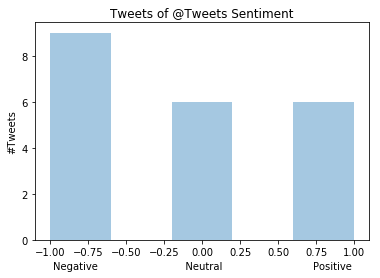

#---------------------------------------------------------------------------------------------------------------------------

RUNVMC1 2019-06-11 17:29:05 ['  BrianKarem  realDonaldTrump I loved it when he held out the piece of paper about the Mexico agreement. So much drama. Wh']
O sentimento da mensagem é POSITIVE



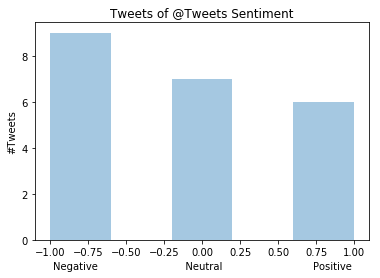

#---------------------------------------------------------------------------------------------------------------------------

tee10202 2019-06-11 17:29:05 [' PrimeCreator2  malgratz11  AboveTheBurgh  GM062616  SCOTTDHELTON  HeARTofGod99  kerrijacobi  dtrastikeville ']
O sentimento da mensagem é NEUTRAL



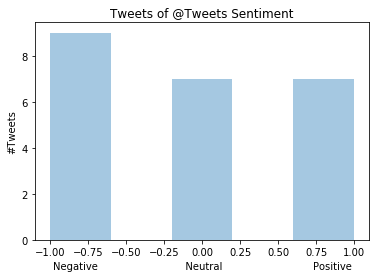

#---------------------------------------------------------------------------------------------------------------------------

SangKatherine 2019-06-11 17:29:05 ['A fuckton of yes to this']
O sentimento da mensagem é POSITIVE



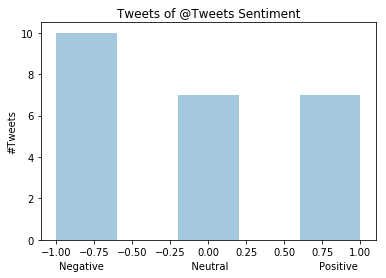

#---------------------------------------------------------------------------------------------------------------------------

FreedomJones5 2019-06-11 17:29:05 ['  TESLA_N_TRUMP  sheeshkabob  realDonaldTrump Meh..hell just tank the economy and the NYSD will prosecute him. He is a t']
O sentimento da mensagem é NEGATIVE



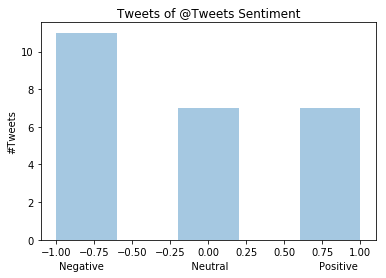

#---------------------------------------------------------------------------------------------------------------------------

2Run26 2019-06-11 17:29:05 [' AhmedBaba_  realDonaldTrump Wrong again idiot. Tariffs are not taxes.']
O sentimento da mensagem é NEGATIVE



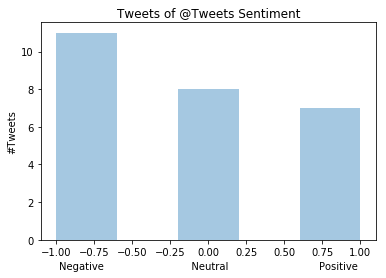

#---------------------------------------------------------------------------------------------------------------------------

Gittelrock 2019-06-11 17:29:05 [' fargolawyer  AaronBlake  maggieNYT Knock me over with a feather. ']
O sentimento da mensagem é NEUTRAL



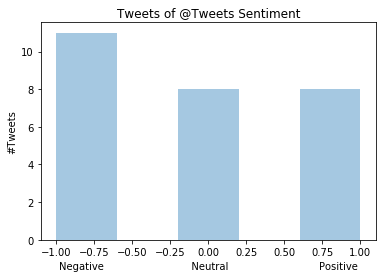

#---------------------------------------------------------------------------------------------------------------------------

kizzy2003 2019-06-11 17:29:05 ['A beautiful looking Garden Snail ( Comu Aspersum ) sitting on raised bed wall #biodiversity ']
O sentimento da mensagem é POSITIVE



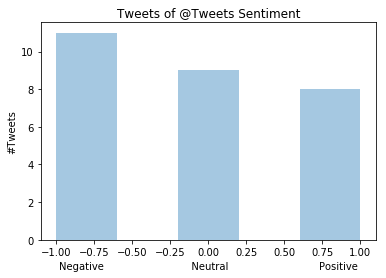

#---------------------------------------------------------------------------------------------------------------------------

BeBeLoveJewelry 2019-06-11 17:29:05 [' kaufmannGOP  realDonaldTrump Yee Haw, the Circus is back in town!']
O sentimento da mensagem é NEUTRAL



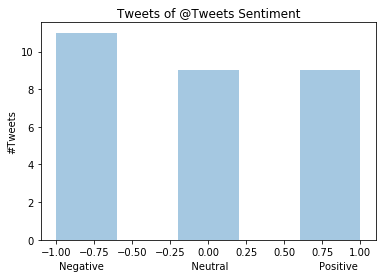

#---------------------------------------------------------------------------------------------------------------------------

mshson 2019-06-11 17:29:05 ['  TheJuanWilliams  realDonaldTrump  thehill  TheHillOpinion The American people voted him in. Accept the election results juan.']
O sentimento da mensagem é POSITIVE



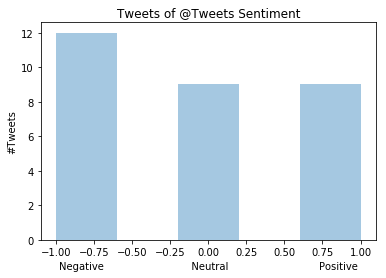

#---------------------------------------------------------------------------------------------------------------------------

luigih1961 2019-06-11 17:29:05 ['  TeamTrump knows that pushing against the grain can pay off. \n\nWhen we spent money in WI and MI in 2016 and sent  realDonald']
O sentimento da mensagem é NEGATIVE



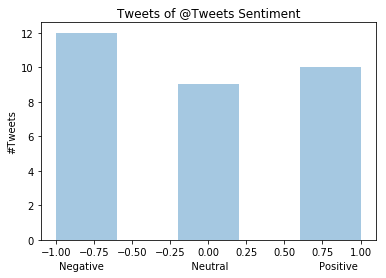

#---------------------------------------------------------------------------------------------------------------------------

crumcasa 2019-06-11 17:29:05 [' TheJuanWilliams  realDonaldTrump  thehill  TheHillOpinion Juan, What will your excuse be when Donald Trump wins by ']
O sentimento da mensagem é POSITIVE



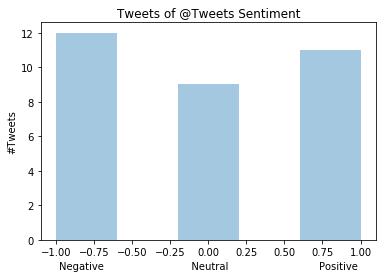

#---------------------------------------------------------------------------------------------------------------------------

mollydazed 2019-06-11 17:29:05 [' Incredible news, senators and congressmen want us to build more wall for the government privately on a parallel path with']
O sentimento da mensagem é POSITIVE



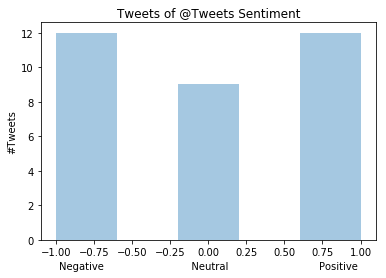

#---------------------------------------------------------------------------------------------------------------------------

jonreaksmey 2019-06-11 17:29:05 ['Happy #Halloween - Floor #Pillow Also Available on #LapTops #TankTop #Mugs #Hoodies Wall Prints #PhoneCases ']
O sentimento da mensagem é POSITIVE



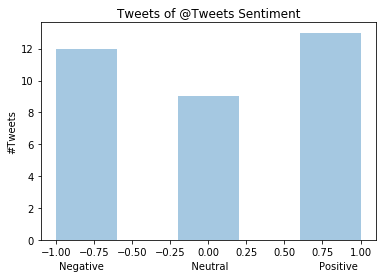

#---------------------------------------------------------------------------------------------------------------------------

JTwitAcct 2019-06-11 17:29:06 [' Weve no idea where this horde is coming from, lets have some fun with it &amp; get some reform too  realDonaldTrump \n\n CBP']
O sentimento da mensagem é POSITIVE



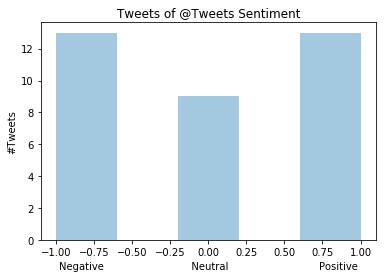

#---------------------------------------------------------------------------------------------------------------------------

MAMike4 2019-06-11 17:29:06 [' Three times POTUS tells me to be quiet as I ask him about the accusations he is lying to the American public.  realDonaldT']
O sentimento da mensagem é NEGATIVE



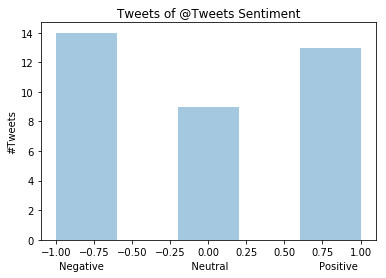

#---------------------------------------------------------------------------------------------------------------------------

nashvillestacy 2019-06-11 17:29:05 [' realDonaldTrump Poor, scare little baby hands  ']
O sentimento da mensagem é NEGATIVE



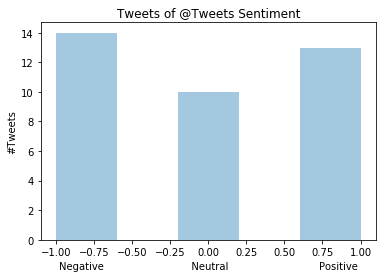

#---------------------------------------------------------------------------------------------------------------------------

ERGA497511 2019-06-11 17:29:06 [' .OUTRAGEOUS! 350 IllGAL MIGRANTS from the Congo arrived in San Antonio &amp; more are on their way! \nWhen do we say ENOUGH IS']
O sentimento da mensagem é NEUTRAL



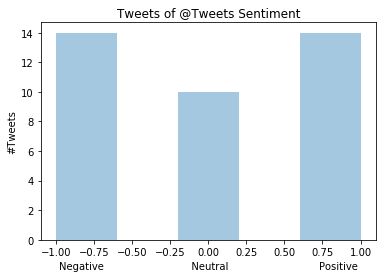

#---------------------------------------------------------------------------------------------------------------------------

Saunders_HS 2019-06-11 17:29:06 ['Saunders High School 2019 Wall of Fame Ceremony']
O sentimento da mensagem é POSITIVE



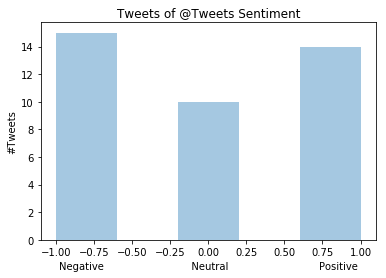

#---------------------------------------------------------------------------------------------------------------------------

Hey_Deb_21 2019-06-11 17:29:06 ['  realDonaldTrump Liberals dont debate, they harass and hate! \n\nA few instances: \n\nThey chased DHS Sec Nielsen from a Mexica']
O sentimento da mensagem é NEGATIVE



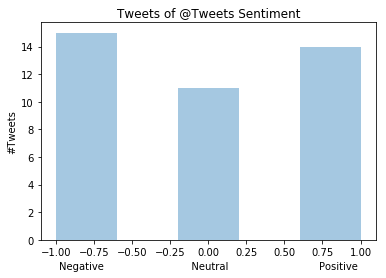

#---------------------------------------------------------------------------------------------------------------------------

citizen311 2019-06-11 17:29:06 ['  realDonaldTrump\nThread by  tburages: "This thread contains images with passages from the Mueller Report. I will add new on']
O sentimento da mensagem é NEUTRAL



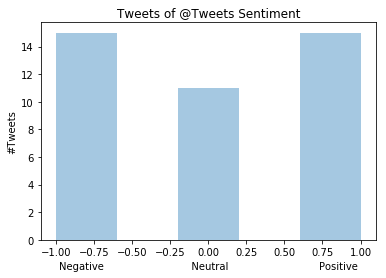

#---------------------------------------------------------------------------------------------------------------------------

QQBeautifulDove 2019-06-11 17:29:06 [' You cant make this up.\n\nThe best person Jerry Nadler could find to smear  realDonaldTrump today with a bogus obstructi']
O sentimento da mensagem é POSITIVE



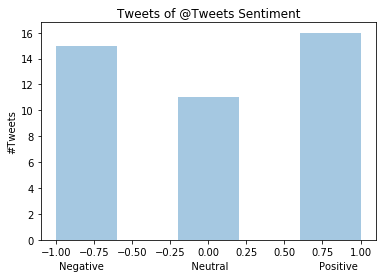

#---------------------------------------------------------------------------------------------------------------------------

Janeway12004 2019-06-11 17:29:02 [' Trumps secret agreement with Mexico is as believable as Mexico paying for the wall']
O sentimento da mensagem é POSITIVE



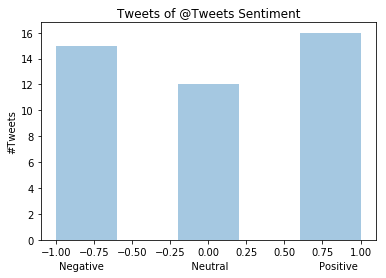

#---------------------------------------------------------------------------------------------------------------------------

isaiahreice21 2019-06-11 17:29:05 [' Cleaning the sea &gt; building the wall ']
O sentimento da mensagem é NEUTRAL



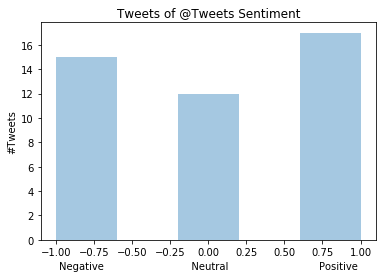

#---------------------------------------------------------------------------------------------------------------------------

ryoatl 2019-06-11 17:29:05 ['  americanconsnet  sford005  Mountainaires  realDonaldTrump I am running in Texas 32nd CD against an Obama endorsed Demo']
O sentimento da mensagem é POSITIVE



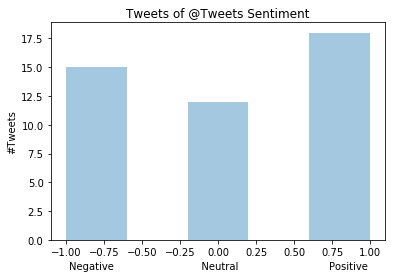

#---------------------------------------------------------------------------------------------------------------------------

kimmwaters4 2019-06-11 17:29:06 [' T-Minus ONE WEEK until President  realDonaldTrump launches his reelection campaign from Orlando, FL! \n\nJoin RSBN for ALL DA']
O sentimento da mensagem é POSITIVE



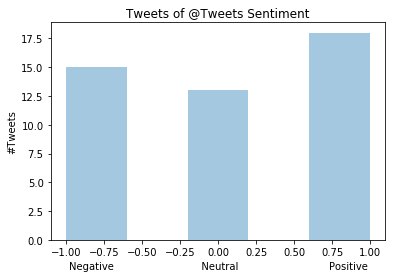

#---------------------------------------------------------------------------------------------------------------------------

genbiebz 2019-06-11 17:29:06 [' This gonna be adult me when my kids start banging on my wall waking me up at 3 AM telling me they threw up ']
O sentimento da mensagem é NEUTRAL



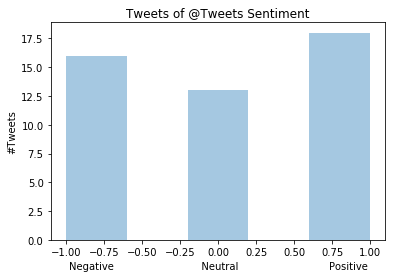

#---------------------------------------------------------------------------------------------------------------------------

lostigerfilms 2019-06-11 17:29:06 ['  realDonaldTrump STOP THE PRESIDENTIAL HARASSMENT!\n realDonaldTrump ']
O sentimento da mensagem é NEGATIVE



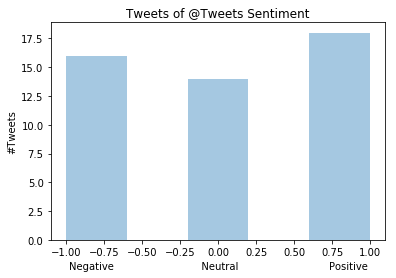

#---------------------------------------------------------------------------------------------------------------------------

ChrisWh71957972 2019-06-11 17:29:06 [' UneedHMiCANbHM  randor10  EMPosts  WoodfordCHNL  nncattan  realDonaldTrump I have been around since before your da ']
O sentimento da mensagem é NEUTRAL



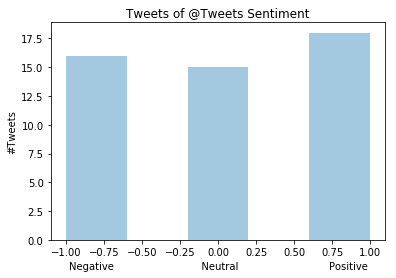

#---------------------------------------------------------------------------------------------------------------------------

TimODee16 2019-06-11 17:29:06 ['Its just the Orchids of Asia roster.']
O sentimento da mensagem é NEUTRAL



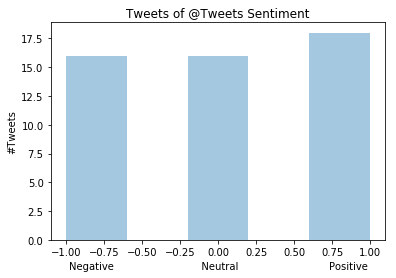

#---------------------------------------------------------------------------------------------------------------------------

latinstudi 2019-06-11 17:29:06 [' Mirror mirror on the wall \n ']
O sentimento da mensagem é NEUTRAL



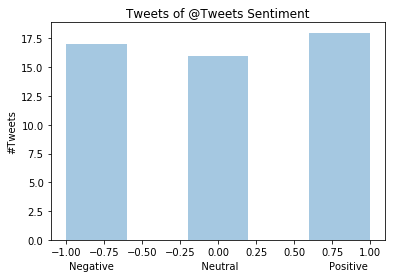

#---------------------------------------------------------------------------------------------------------------------------

NevadaElJefe 2019-06-11 17:29:06 [' So tired of #Congress obstructing our  POTUS s plans for #Winning . #Democrats dont want to work for #WeThePeople We ele']
O sentimento da mensagem é NEGATIVE



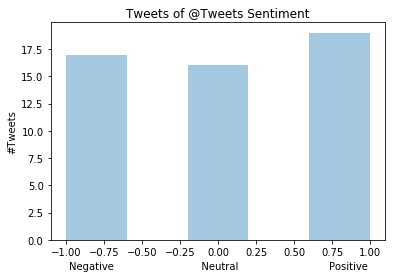

#---------------------------------------------------------------------------------------------------------------------------

theSacredRebel 2019-06-11 17:29:06 [" They're going to wish they'd never messed with him.\n "]
O sentimento da mensagem é POSITIVE



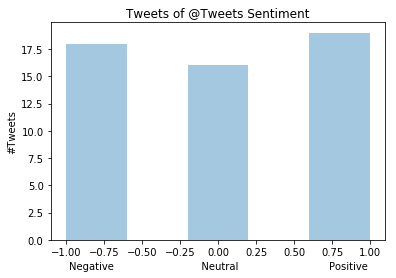

#---------------------------------------------------------------------------------------------------------------------------

ICanBeAHandful 2019-06-11 17:29:06 ["These people and their childish BS.\n\nLet's wave around a blank piece of paper, that's totally believable."]
O sentimento da mensagem é NEGATIVE



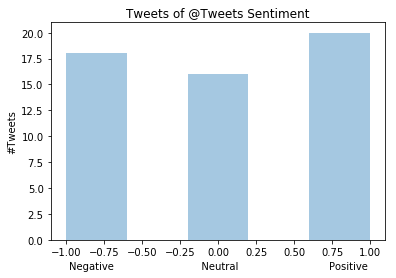

#---------------------------------------------------------------------------------------------------------------------------

OrbHalo 2019-06-11 17:29:06 [' Weve no idea where this horde is coming from, lets have some fun with it &amp; get some reform too  realDonaldTrump \n\n CBP']
O sentimento da mensagem é POSITIVE



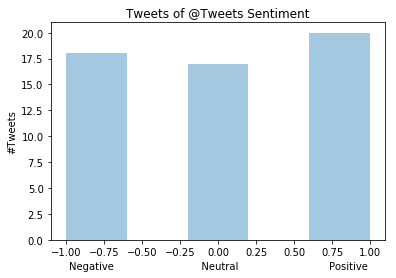

#---------------------------------------------------------------------------------------------------------------------------

awakechaos 2019-06-11 17:29:06 [' POTUS holds up what appears to be a blank piece of paper claiming it contains the Mexican deal. Refuses to answer when I as']
O sentimento da mensagem é NEUTRAL



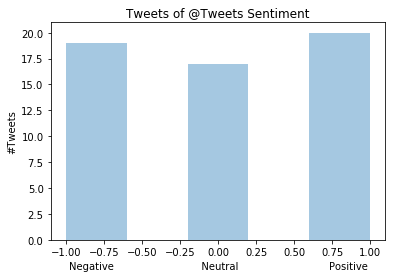

#---------------------------------------------------------------------------------------------------------------------------

BobbiKi88765183 2019-06-11 17:29:06 [' Spiritual War of Good vs Evil \n\nI hope people realize that this is the type of war that it is? \n\nAngel Warriors vs demon']
O sentimento da mensagem é NEGATIVE



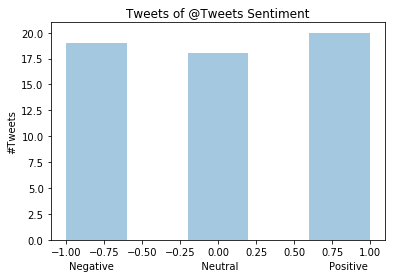

#---------------------------------------------------------------------------------------------------------------------------

llccar1 2019-06-11 17:29:06 [' CaslerNoel  realDonaldTrump  SenRickScott ']
O sentimento da mensagem é NEUTRAL



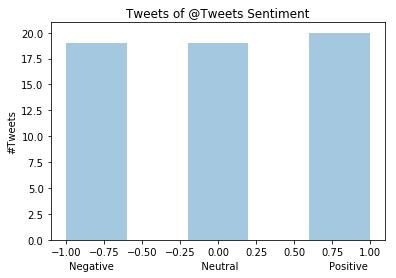

#---------------------------------------------------------------------------------------------------------------------------

ioncorruption 2019-06-11 17:29:05 ['  newtgingrich  realDonaldTrump ']
O sentimento da mensagem é NEUTRAL



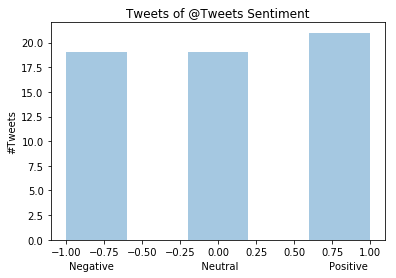

#---------------------------------------------------------------------------------------------------------------------------

Forever_patch 2019-06-11 17:29:07 [' jungkook and hoseok really are those annoying kind of friends that you absolutely love but you also wish to smash their head']
O sentimento da mensagem é POSITIVE



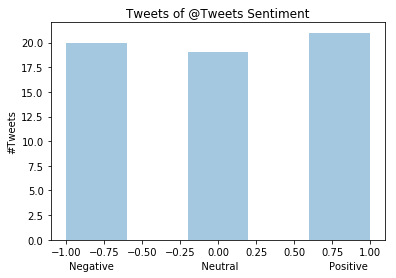

#---------------------------------------------------------------------------------------------------------------------------

ngrealy 2019-06-11 17:29:07 ['As a #ProLife American, thank you  realDonaldTrump &amp;  SecAzar for your pro-life leadership to STOP the barbaric exp ']
O sentimento da mensagem é NEGATIVE



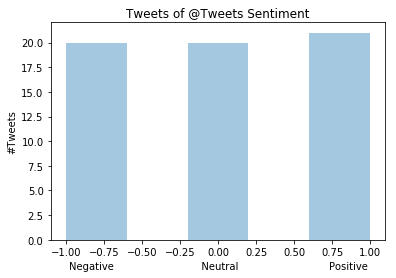

#---------------------------------------------------------------------------------------------------------------------------

chrislee1628 2019-06-11 17:29:07 [' raggapegs  realDonaldTrump  SpeakerPelosi Mummy issues']
O sentimento da mensagem é NEUTRAL



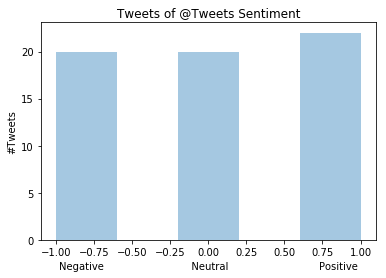

#---------------------------------------------------------------------------------------------------------------------------

kronn 2019-06-11 17:29:07 [' realDonaldTrump Resign and it will all go away. JK #CriminalInvestigation']
O sentimento da mensagem é POSITIVE



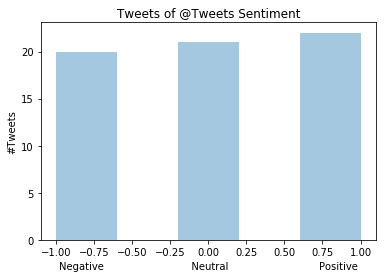

#---------------------------------------------------------------------------------------------------------------------------

poseidonlilgurl 2019-06-11 17:29:07 [' This gonna be adult me when my kids start banging on my wall waking me up at 3 AM telling me they threw up ']
O sentimento da mensagem é NEUTRAL



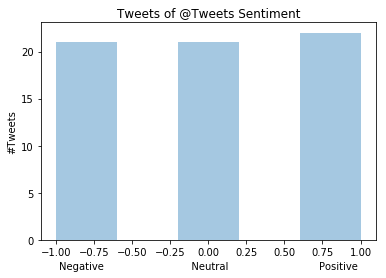

#---------------------------------------------------------------------------------------------------------------------------

erkherd 2019-06-11 17:29:07 [' realDonaldTrump Your own team knows you are a loser.']
O sentimento da mensagem é NEGATIVE



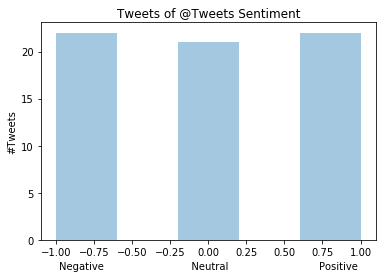

#---------------------------------------------------------------------------------------------------------------------------

atxed1 2019-06-11 17:29:07 [' kayleighmcenany The biggest flip flop in US history is  realDonaldTrump. Why dont you call him up on his flips? Fake blonde fake Christian']
O sentimento da mensagem é NEGATIVE



KeyboardInterrupt: 

In [25]:
#filter_track = ['realDonaldTrump','wall']
#filter_track = ['jairbolsonaro','previdencia']

print('-------------------------------------------------------------')
print('API TWITTER Portuguese ANALYZER')
print('-------------------------------------------------------------')
print('Please Type the filter that you want to analyze in Twitter')
print('e.g. "jairbolsonaro" and "previdencia"')
print('To FINISH, press ctrl+c and visualize the sentimental graph')

filter_track1 = input('First filter: ')
filter_track2 = input('Second filter: ')
filter_track = [filter_track1, filter_track2]
twitter_stream_listener(filter_track)